In [1]:
%matplotlib inline

Process a high-resolution image
===============================

This example shows how to use `squidpy.im.process` with tiling.

The function can be applied to any method (e.g., smoothing, conversion
to grayscale) or `layer` of a high-resolution image layer of
`squidpy.im.ImageContainer`.

By default, `squidpy.im.process` processes the entire input image at
once. In the case of high-resolution tissue slides however, the images
might be too big to fit in memory and cannot be processed at once. In
that case you can use the argument `chunks` to tile the image in crops
of shape `chunks`, process each crop, and re-assemble the resulting
image. Note that you can also use `squidpy.im.segment` in this manner.

Note that depending on the processing function used, there might be
border effects occurring at the edges of the crops. Since Squidpy is
backed by `dask`, and internally chunking is done using
`dask.array.map_overlap`, dealing with these border effects is easy.
Just specify the `depth` and `boundary` arguments in the `apply_kwargs`
upon the call to `squidpy.im.process`. For more information, please
refer to the documentation of `dask.array.map_overlap`.

For the build in processing functions, [gray]{.title-ref} and
[smooth]{.title-ref}, the border effects are already automatically taken
care of, so it is not necessary to specify `depth` and `boundary`. For
`squidpy.im.segment`, the default `depth` is 30, which already takes
care of most severe border effects.

:::{seealso}
-   `examples_image_compute_smooth`.
-   `examples_image_compute_gray`.
-   `examples_image_compute_segment_fluo`.

:::


In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

import squidpy as sq

Built-in processing functions
=============================


In [4]:
# load the H&E stained tissue image
img = sq.datasets.visium_hne_image()

We will process the image by tiling it in crops of shape
`chunks = (1000, 1000)`.


In [5]:
sq.im.process(img, layer="image", method="gray", chunks=1000)

Now we can look at the result on a cropped part of the image.


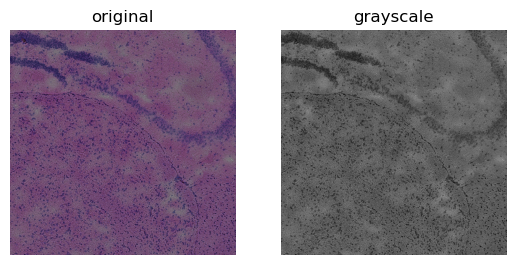

In [6]:
crop = img.crop_corner(4000, 4000, size=2000)

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("original")
crop.show("image_gray", cmap="gray", ax=axes[1])
_ = axes[1].set_title("grayscale")

Custom processing functions
===========================

Here, we use a custom processing function (here
`scipy.ndimage.gaussian_filter`) with chunking to showcase the `depth`
and `boundary` arguments.

Lets use a simple image and choose the chunk size in such a way to
clearly see the differences between using overlapping crops and
non-overlapping crops.


In [7]:
arr = np.zeros((20, 20))
arr[10:] = 1
img = sq.im.ImageContainer(arr, layer="image")

# smooth the image using `depth` 0 and 1
sq.im.process(
    img,
    layer="image",
    method=gaussian_filter,
    layer_added="smooth_depth0",
    chunks=10,
    sigma=1,
    apply_kwargs={"depth": 0},
)
sq.im.process(
    img,
    layer="image",
    method=gaussian_filter,
    layer_added="smooth_depth1",
    chunks=10,
    sigma=1,
    apply_kwargs={"depth": 1, "boundary": "reflect"},
)

Plot the difference in results. Using overlapping blocks with
`depth = 1` removes the artifacts at the borders between chunks.


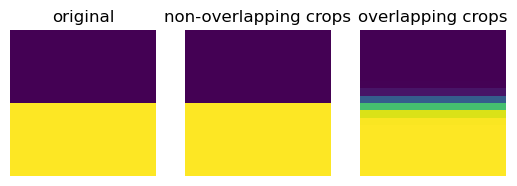

In [8]:
fig, axes = plt.subplots(1, 3)
img.show("image", ax=axes[0])
_ = axes[0].set_title("original")
img.show("smooth_depth0", ax=axes[1])
_ = axes[1].set_title("non-overlapping crops")
img.show("smooth_depth1", ax=axes[2])
_ = axes[2].set_title("overlapping crops")